In [1]:
from Agent import Agent
from Game import SnakeGameAI
from helper import training_loop, plot, ax_plot
from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

Output = namedtuple('Output', ['agent', 'scores', 'mean_scores'])

pygame 2.1.2 (SDL 2.0.16, Python 3.8.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default


Calibrate epsilon for shorter training periods: we want it to decay to a low level by the end of the training.

We plot epsilon decay below to check that our chosen update parameters lead epsilon is decaying similarly from start to finish for experiments with number of episodes from 150 to 250.

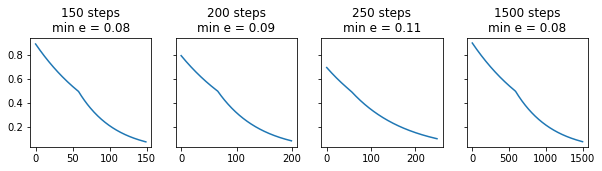

In [27]:
def epsilon_decay(steps, e, e_decay, min_e=0.05):
    a = np.ones(steps) * e_decay[0]
    b = np.ones(steps) * e_decay[1]
    aa = np.cumproduct(a) * e
    bb = np.cumproduct(b) * e
    thresh_idx = np.argmax(aa < 0.5)
    eps = np.where(aa > 0.5, aa,
                   aa[thresh_idx] / bb[thresh_idx] * bb)
    eps = np.where(eps > min_e, eps, min_e)
    return eps

fig, axs = plt.subplots(1,4,sharey=True, figsize=(10,2))

eps_list = []
eps_list.append(epsilon_decay(150, 0.9, [0.99, 0.98]))
eps_list.append(epsilon_decay(200, 0.8, [0.993, 0.987]))
eps_list.append(epsilon_decay(250, 0.7, [0.994, 0.992]))
eps_list.append(epsilon_decay(1500, 0.9, [0.999, 0.998]))
steps_list = [150, 200, 250, 1500]


for i, ax in enumerate(axs.flatten()):
    ax.plot(eps_list[i])
    ax.set_title("{} steps\nmin e = {:.2f}"
                 .format(steps_list[i], eps_list[i][-1]))
                 
plt.show()

## Curriculum Learning

### First stage

First we train the agent on a really small grid - equivalent to 6 x 6 blocks.

The intuition is that the snake will spend more time learning to avoid walls, and also be more likley to randomly eat a rat and discover that it's worth finding the rat when the grid is smaller.

### Second stage

Now we train the agent on a slightly larger grid: 10 x 10 blocks.

The grid is large enough the the snake's observation field (5 x 5 blocks surrounding snakes head) is always missing quite a bit of information about the full environment. The snake should train to factor in the relative lack of information.

In [3]:
UI = False
TRAINING_EPISODES = 150
EVAL_EPISODES = 30
GET_OBS = 'surroundings'
DOUBLE_DQN = False
DUELING_DQN = True
MODEL_NAME = 'small_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.99, 0.98]}
curriculum_output = {}

game_kwargs = {'width': 120, 'height': 120, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=MODEL_NAME,
                                           load_model=False,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(MODEL_NAME)
curriculum_output[MODEL_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

################
# SECOND STAGE:
################


TRAINING_EPISODES = 200
LOAD_NAME = 'small_grid.pth'
SAVE_NAME = 'medium_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 200, 'height': 200, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

display.clear_output()

keys = list(curriculum_output.keys())
titles = ['small grid training', 'medium grid training']
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

for i, ax in enumerate(axs.flatten()):
    ax_plot(ax, curriculum_output[keys[i]].scores,
            curriculum_output[keys[i]].mean_scores,
            title=titles[i])
fig.tight_layout()
plt.show()

### Zero shot

Evaluate the model trained so far on the full-sized grid. How does it compete with the other agents that have trained for 1500 episodes on the full-sized grid?

It does! The agent outperforms all previous agents despite having only trained for 300 episodes on very simple problems.

<Figure size 432x288 with 0 Axes>

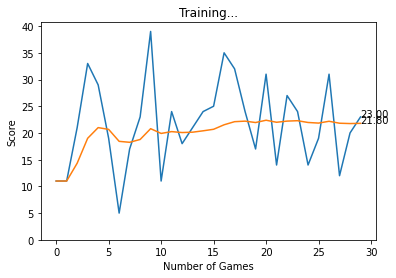

30


In [17]:
# using new obserations
LOAD_NAME = 'medium_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

zero_shot_output = Output(agent, scores, mean_scores)

### Train on full-sized grid - epsilon starts at 0.9

Now train on full-sized grid. After this training, the agent will have trained for a total of 150 + 200 + 250 = 600 episodes. Just over one-third of the training time of the other agents. 

<Figure size 432x288 with 0 Axes>

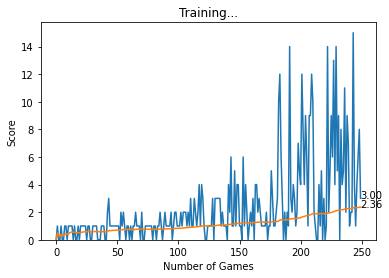

250


In [8]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_grid.pth'
SAVE_NAME = 'full_grid.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.994, 0.987]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluation of full-sized grid training, epsilon = 0.9

<Figure size 432x288 with 0 Axes>

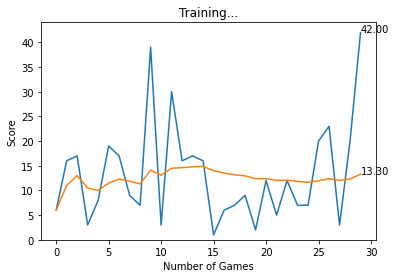

30


In [18]:
# using new obserations
LOAD_NAME = 'full_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### Third round: train on full-sized grid, epsilon starts at 0.5

<Figure size 432x288 with 0 Axes>

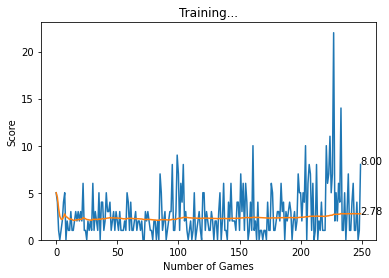

250


In [12]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_grid.pth'
SAVE_NAME = 'full_gridv2.pth'
EPS_KW = {'epsilon': 0.5, 'epsilon_decay':[0.994, 0.994]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate: full-sized grid, third round, epsilon = 0.5

<Figure size 432x288 with 0 Axes>

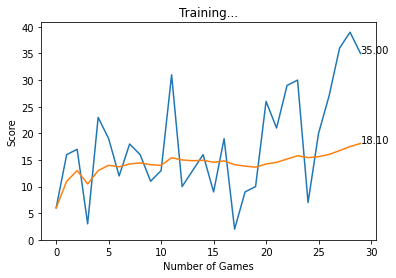

30


In [20]:
# using new obserations
LOAD_NAME = 'full_gridv2.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### Try third round on "medium-plus" grid

The jump from a 10x10 to a 32x24 grid is quite big. What happens if we train on a 20x16 grid as a third round and then evaluate on zero shot or fourth round of training on full-sized grid?

<Figure size 432x288 with 0 Axes>

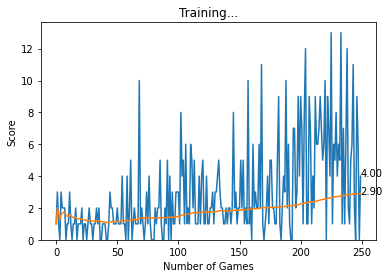

250


In [15]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_grid.pth'
SAVE_NAME = 'medium_plus_grid.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 400, 'height': 320, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Zero shot evaluation after 3 rounds of curriculum training

<Figure size 432x288 with 0 Axes>

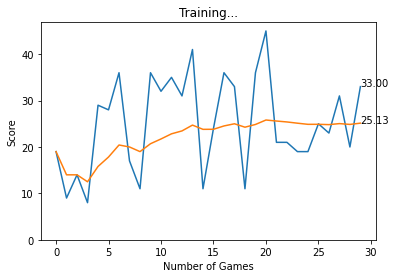

30


In [19]:
# using new obserations
LOAD_NAME = 'medium_plus_grid.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### 4th round of training - full-sized grid, epsilon = 0.7

This agent has trainded on 6x6, 10x10, 10x16 and finall on 32x24.

<Figure size 432x288 with 0 Axes>

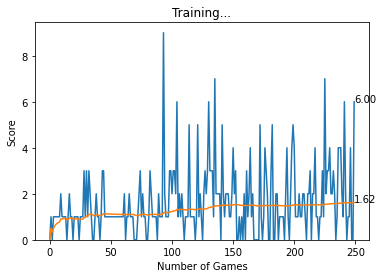

250


In [24]:
TRAINING_EPISODES = 250
LOAD_NAME = 'medium_plus_grid.pth'
SAVE_NAME = 'full_gridv3.pth'
EPS_KW = {'epsilon': 0.7, 'epsilon_decay':[0.994, 0.992]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

### Evaluate after 4 training rounds

<Figure size 432x288 with 0 Axes>

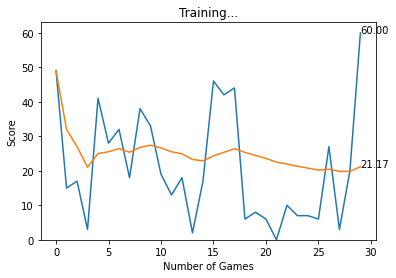

30


In [25]:
# using new obserations
LOAD_NAME = 'full_gridv3.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

eval_output = Output(agent, scores, mean_scores)


### Reduce starting epsilon for second stage

IndexError: list index out of range

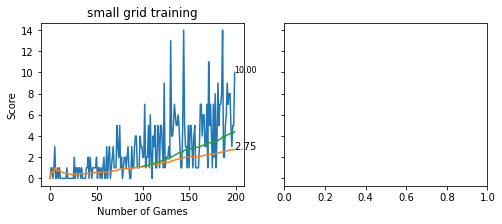

In [22]:
UI = False
TRAINING_EPISODES = 150
EVAL_EPISODES = 30
GET_OBS = 'surroundings'
DOUBLE_DQN = False
DUELING_DQN = True
MODEL_NAME = 'small_gridv2.pth'
EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.99, 0.98]}
curriculum_output = {}

game_kwargs = {'width': 120, 'height': 120, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=MODEL_NAME,
                                           load_model=False,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(MODEL_NAME)
curriculum_output[MODEL_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

################
# SECOND STAGE:
################


TRAINING_EPISODES = 200
LOAD_NAME = 'small_gridv2.pth'
SAVE_NAME = 'medium_gridv2.pth'
EPS_KW = {'epsilon': 0.8, 'epsilon_decay':[0.993, 0.987]}

game_kwargs = {'width': 200, 'height': 200, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=True,
                                           epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=TRAINING_EPISODES,
                                           plot_update_at_end=True
                                          )
agent.save_model(SAVE_NAME)
curriculum_output[SAVE_NAME.split(',')[0]] = Output(agent, scores, mean_scores)

display.clear_output()

keys = list(curriculum_output.keys())
titles = ['small grid training', 'medium grid (eps=0.8) training']
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))

for i, ax in enumerate(axs.flatten()):
    ax_plot(ax, curriculum_output[keys[i]].scores,
            curriculum_output[keys[i]].mean_scores,
            title=titles[i])
fig.tight_layout()
plt.show()

### Does zero shot improve after reduced epsilon?

<Figure size 432x288 with 0 Axes>

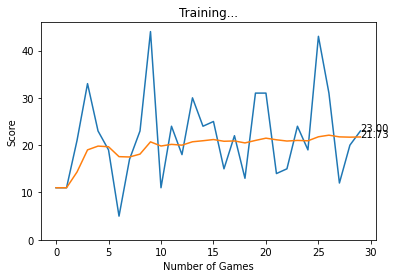

30


In [23]:
# using new obserations
LOAD_NAME = 'medium_gridv2.pth'
# SAVE_NAME = 'medium_grid.pth'
# EPS_KW = {'epsilon': 0.9, 'epsilon_decay':[0.992, 0.985]}

game_kwargs = {'width': 640, 'height': 480, 'UI': UI,
                'window_title': "{}".format(GET_OBS)}

agent, scores, mean_scores = training_loop(game_kwargs=game_kwargs,
                                           model_name=LOAD_NAME,
                                           load_model=True,
                                           get_observation=GET_OBS,
                                           greedy=False,
                                           # epsilon_kwargs=EPS_KW,
                                           double_dqn=DOUBLE_DQN,
                                           dueling_dqn=DUELING_DQN,
                                           num_episodes=EVAL_EPISODES,
                                           plot_update_at_end=True,
                                           random_seed=1
                                          )

zero_shot_output = Output(agent, scores, mean_scores)